<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/xgboost_lime_shap_deepseek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (120542, 214)

First 5 rows:
   day_1_access  day_1_problem  day_1_wiki  day_1_discussion  day_1_navigate  \
0             3              8           0                 0               1   
1             7             14           0                 0               4   
2            18              5           0                 0               4   
3             0              0           0                 0               2   
4            12              2           0                 0               5   

   day_1_page_close  day_1_video  day_2_access  day_2_problem  day_2_wiki  \
0                 1            0             0              0           0   
1                 2            1             0              0           0   
2                 2            2             0              0           0   
3                 0            0            28             16           0   
4                 2            2             0              0           0   

   ...  day_

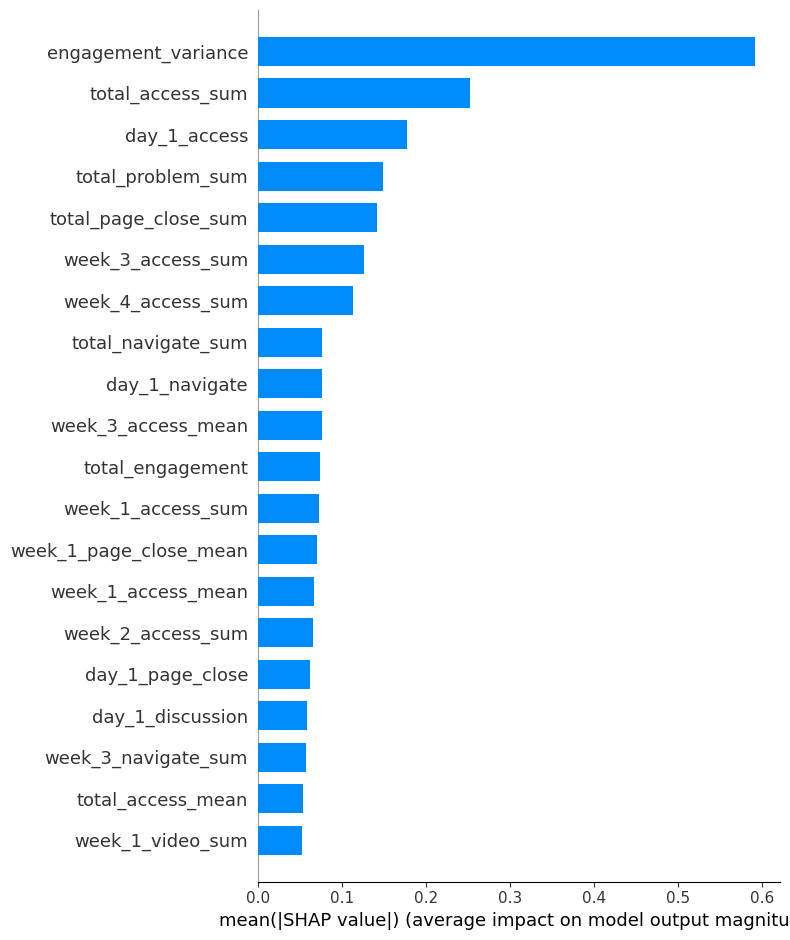

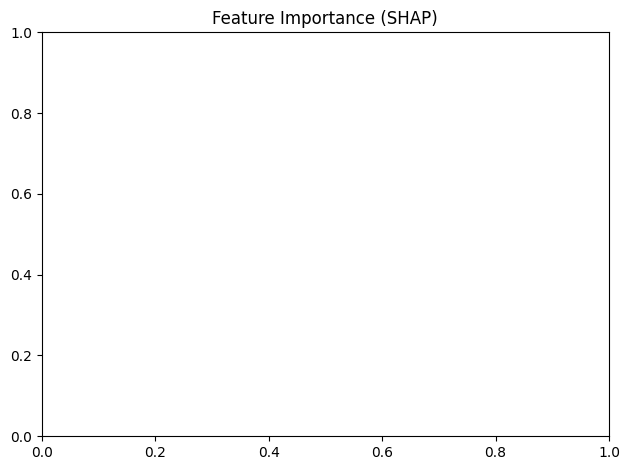

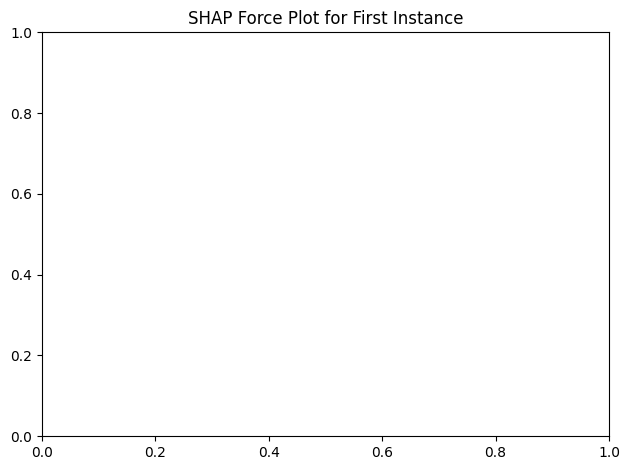


Model Feature Importances:


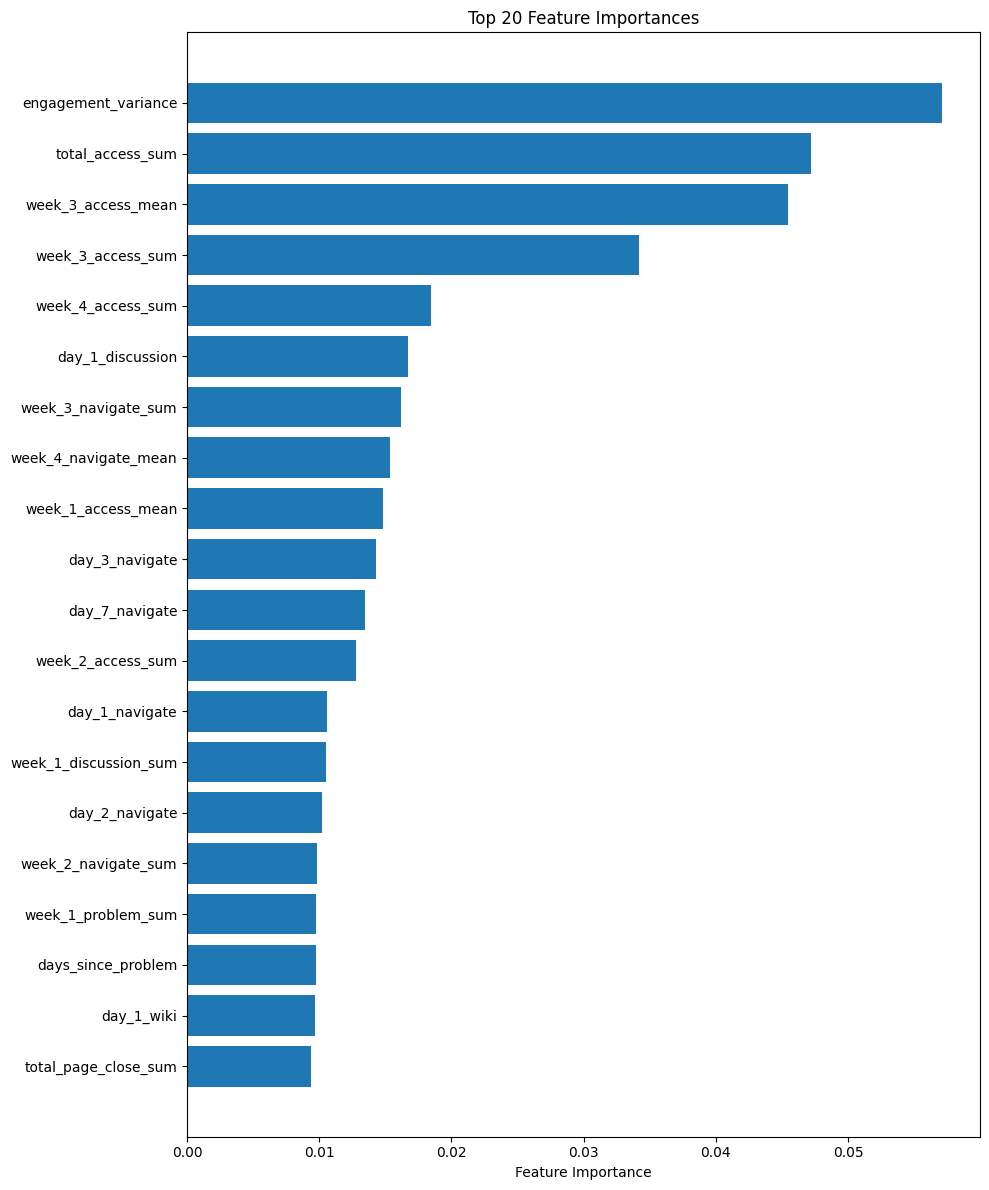


Partial Dependence Plots for Top Features: ['week_4_access_sum' 'week_3_access_sum' 'week_3_access_mean'
 'total_access_sum' 'engagement_variance']


<Figure size 1200x800 with 0 Axes>

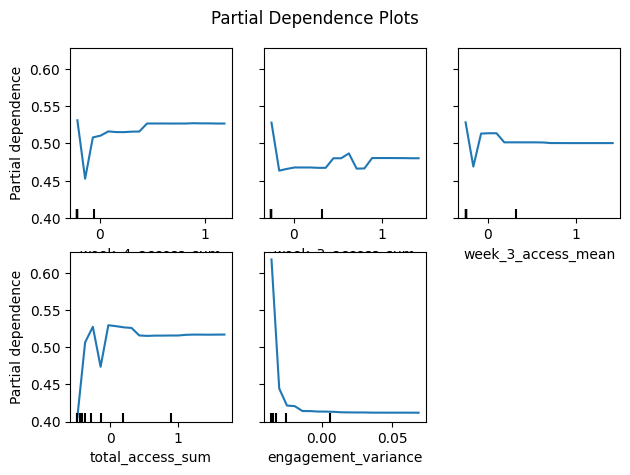

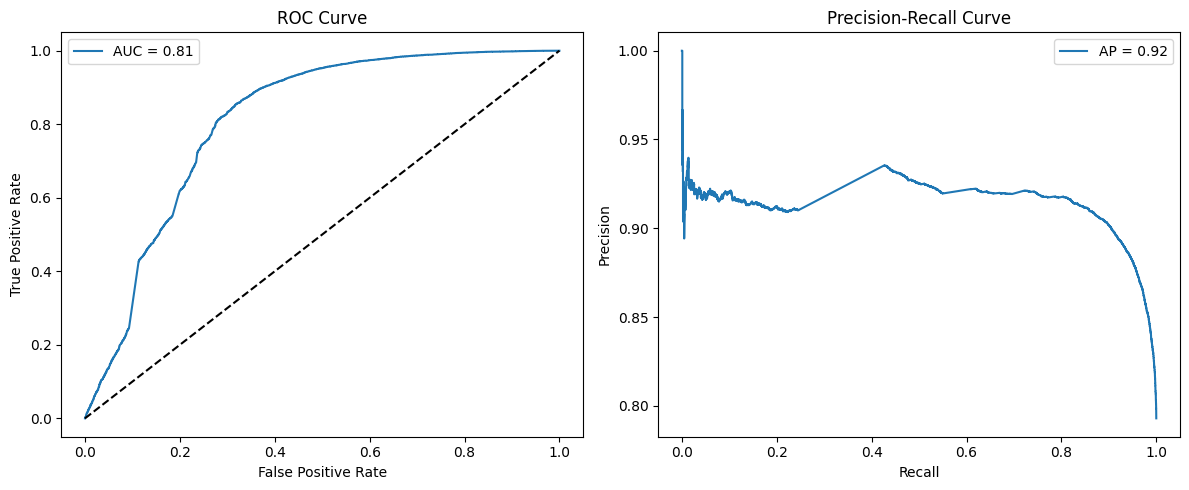


Optimizing decision threshold...
Best threshold: 0.17 with F1 score: 0.9152

Performance with optimized threshold:
              precision    recall  f1-score   support

           0       0.78      0.43      0.56      4992
           1       0.87      0.97      0.92     19117

    accuracy                           0.86     24109
   macro avg       0.82      0.70      0.74     24109
weighted avg       0.85      0.86      0.84     24109

Confusion Matrix:
[[ 2167  2825]
 [  606 18511]]


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, precision_recall_curve,
                            average_precision_score, f1_score)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

# Load and explore the dataset
def load_and_explore_data(file_path):
    """Load the dataset and perform initial exploration"""
    data = pd.read_csv(file_path)

    print("Dataset shape:", data.shape)
    print("\nFirst 5 rows:")
    print(data.head())

    # Check for missing values
    print("\nMissing values per column:")
    print(data.isnull().sum())

    # Check class distribution
    print("\nClass distribution:")
    print(data['dropout'].value_counts(normalize=True))

    return data

# Feature engineering
def create_features(data):
    """Create additional features from the raw data"""
    # Drop non-feature columns
    X = data.drop(['enrollment_id', 'username', 'course_id', 'dropout'], axis=1)
    y = data['dropout']

    activities = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']

    # Create weekly aggregates
    for activity in activities:
        for week in range(4):
            start_day = week * 7 + 1
            end_day = (week + 1) * 7
            cols = [f'day_{d}_{activity}' for d in range(start_day, end_day+1)]
            X[f'week_{week+1}_{activity}_sum'] = X[cols].sum(axis=1)
            X[f'week_{week+1}_{activity}_mean'] = X[cols].mean(axis=1)

        # Total activity features
        cols = [f'day_{d}_{activity}' for d in range(1, 31)]
        X[f'total_{activity}_sum'] = X[cols].sum(axis=1)
        X[f'total_{activity}_mean'] = X[cols].mean(axis=1)

    # Activity duration features
    for activity in activities:
        activity_cols = [f'day_{d}_{activity}' for d in range(1, 31)]
        # Last day with activity
        last_active = X[activity_cols].gt(0).idxmax(axis=1)
        X[f'last_active_day_{activity}'] = last_active.str.extract('(\d+)').astype(float)
        # Days since last activity
        X[f'days_since_{activity}'] = 30 - X[f'last_active_day_{activity}']

    # Engagement pattern features
    X['total_engagement'] = X[[f'total_{act}_sum' for act in activities]].sum(axis=1)
    X['engagement_variance'] = X[[f'total_{act}_sum' for act in activities]].var(axis=1)

    return X, y

# Model training and evaluation
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train multiple models and evaluate their performance"""

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
        "XGBoost": XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                    random_state=42),
        "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_smote, y_train_smote)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Store results
        results[name] = {
            'model': model,
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'average_precision': average_precision_score(y_test, y_proba),
            'f1_score': f1_score(y_test, y_pred)
        }

        # Print results
        print(f"\n{name} Performance:")
        print("Classification Report:")
        print(results[name]['classification_report'])
        print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
        print(f"Average Precision: {results[name]['average_precision']:.4f}")
        print("Confusion Matrix:")
        print(results[name]['confusion_matrix'])

    return results, scaler

# Hyperparameter tuning
def hyperparameter_tuning(X_train, y_train):
    """Perform hyperparameter tuning for best performing model"""

    # We'll tune XGBoost as it typically performs well
    print("\nPerforming hyperparameter tuning for XGBoost...")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    # Define parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    }

    # Create base model
    xgb = XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        eval_metric='logloss'
    )

    # Grid search with cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='roc_auc',
        n_jobs=-1,
        cv=kfold,
        verbose=1
    )

    grid_search.fit(X_train_smote, y_train_smote)

    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"Best ROC AUC: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, scaler

# Explainable AI (XAI) functions
def explain_model(model, X_test, feature_names, scaler=None):
    """Provide model explanations using SHAP and feature importance"""

    if scaler:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = X_test

    # SHAP values
    print("\nGenerating SHAP explanations...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled)

    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type="bar")
    plt.title("Feature Importance (SHAP)")
    plt.tight_layout()
    plt.show()

    # Force plot for a specific instance
    plt.figure()
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_scaled[0,:], feature_names=feature_names)
    plt.title("SHAP Force Plot for First Instance")
    plt.tight_layout()
    plt.show()

    # Feature importance from model
    if hasattr(model, 'feature_importances_'):
        print("\nModel Feature Importances:")
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)

        plt.figure(figsize=(10, 12))
        plt.barh(range(len(sorted_idx[-20:])), feature_importance[sorted_idx[-20:]])
        plt.yticks(range(len(sorted_idx[-20:])), np.array(feature_names)[sorted_idx[-20:]])
        plt.xlabel("Feature Importance")
        plt.title("Top 20 Feature Importances")
        plt.tight_layout()
        plt.show()

    # Partial dependence plots for top features
    top_features = np.array(feature_names)[sorted_idx[-5:]]
    print("\nPartial Dependence Plots for Top Features:", top_features)

    plt.figure(figsize=(12, 8))
    PartialDependenceDisplay.from_estimator(
        model,
        X_test_scaled,
        features=top_features,
        feature_names=feature_names,
        grid_resolution=20
    )
    plt.suptitle("Partial Dependence Plots")
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Load and explore data
    file_path = 'model1_210_features.csv'
    data = load_and_explore_data(file_path)

    # Feature engineering
    X, y = create_features(data)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train and evaluate baseline models
    print("\nTraining and evaluating baseline models...")
    results, scaler = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Hyperparameter tuning for best model
    best_model, scaler = hyperparameter_tuning(X_train, y_train)

    # Evaluate tuned model
    X_test_scaled = scaler.transform(X_test)
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    print("\nTuned Model Performance:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Explain the model
    print("\nExplaining the model...")
    explain_model(best_model, X_test, X.columns.tolist(), scaler)

    # Plot ROC and PR curves
    plt.figure(figsize=(12, 5))

    # ROC curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # PR curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f'AP = {average_precision_score(y_test, y_proba):.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Threshold optimization
    print("\nOptimizing decision threshold...")
    f1_scores = []
    thresholds = np.linspace(0.1, 0.9, 50)

    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        f1_scores.append(f1_score(y_test, y_pred_thresh))

    best_thresh = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold: {best_thresh:.2f} with F1 score: {max(f1_scores):.4f}")

    # Evaluate with optimal threshold
    y_pred_opt = (y_proba >= best_thresh).astype(int)
    print("\nPerformance with optimized threshold:")
    print(classification_report(y_test, y_pred_opt))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_opt))

if __name__ == "__main__":
    main()